<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [26]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [27]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [28]:
#Two targets possible: target 1 = two_year_recid and target 2 = is_recid

#target1 = 'two_year_recid'
X1 = compas_2.drop(['two_year_recid', 'id', 'score_text', 'is_recid', 'is_violent_recid', 'sex', 'age_cat', 'race', 'event'],axis=1)
Y1 = compas_2['two_year_recid']

#target2 = "is_recid"
#X2 = compas_2.drop([target2, 'id', 'score_text', 'two_year_recid', 'is_violent_recid],axis=1)
#Y2 = compas_2[target2]


# Train Random Forest Classifier

In [29]:
#--------------Model with target 1: two_year recid----------------

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.3, shuffle = True, stratify = Y1)

model = RandomForestClassifier()
model.fit(X1_train, Y1_train)

#predictions
Y1hat = model.predict(X1_test)
len(Y1hat)

#---------------Model with target 2: is_recid--------------------

#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.3, shuffle = True, stratify = Y2)

#model = RandomForestClassifier()
#model.fit(X2_train, Y2_train)

#predictions
#Y2hat = model.predict(X2_test)
#len(Y2hat)


2165

# Collect the errors

In [30]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Y1hat.tolist()
predictions = predictions.set_index(X1_test.index)
predictions['true_class'] = Y1_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X1_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6309
[[785 404]
 [395 581]]


Selecting 4 labels (FP, FN, TP, TN)

In [31]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(entire_dataset)

      age  decile_score  priors_count  v_decile_score  priors_count.1  \
4372   24             4             1               4               1   
6608   37             2             2               2               2   
1313   45             1             0               1               0   
3915   47             2             3               1               3   
1084   25             8             2               4               2   
...   ...           ...           ...             ...             ...   
1138   34             9            14               8              14   
4990   29             2             6               2               6   
4443   55             2             1               3               1   
5908   79             1             1               1               1   
5966   32             2             2               2               2   

      sex_Female  sex_Male  age_cat_25 - 45  age_cat_Greater than 45  \
4372           1         0                0        

In [32]:
#Check if there are any false positives
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")

There's at least one occurrence of 1 in the column.


# add categorical for error type to make visualizations

In [33]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'age_cat', 'race']], left_index=True, right_index=True)


In [34]:
#change objects to categories
for col in ['sex', 'age_cat', 'race']:
    entire_dataset[col] = entire_dataset[col].astype('category')

entire_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 4372 to 5966
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      2165 non-null   int64   
 1   decile_score             2165 non-null   int64   
 2   priors_count             2165 non-null   int64   
 3   v_decile_score           2165 non-null   int64   
 4   priors_count.1           2165 non-null   int64   
 5   sex_Female               2165 non-null   int64   
 6   sex_Male                 2165 non-null   int64   
 7   age_cat_25 - 45          2165 non-null   int64   
 8   age_cat_Greater than 45  2165 non-null   int64   
 9   age_cat_Less than 25     2165 non-null   int64   
 10  race_African-American    2165 non-null   int64   
 11  race_Asian               2165 non-null   int64   
 12  race_Caucasian           2165 non-null   int64   
 13  race_Hispanic            2165 non-null   int64   
 14  race_


# Barchart 4 labels (FP, FN, TP, TN)

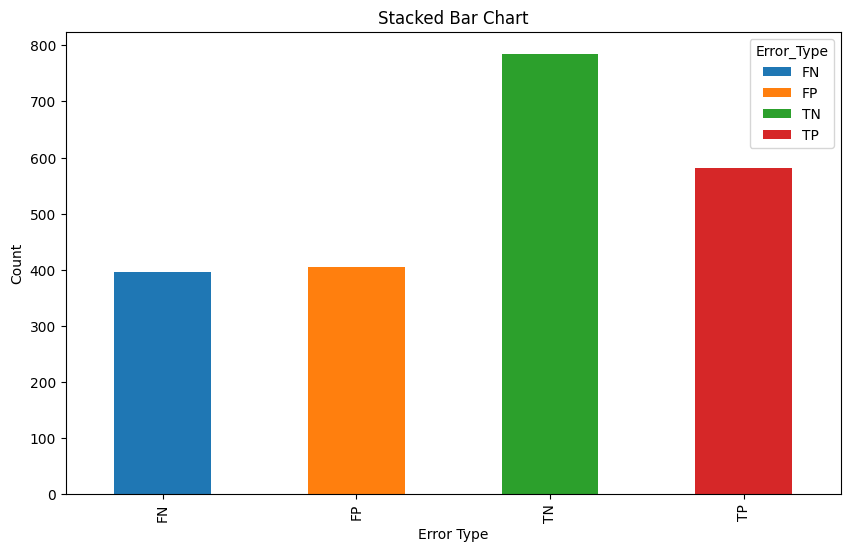

In [35]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart error labels per demographic group

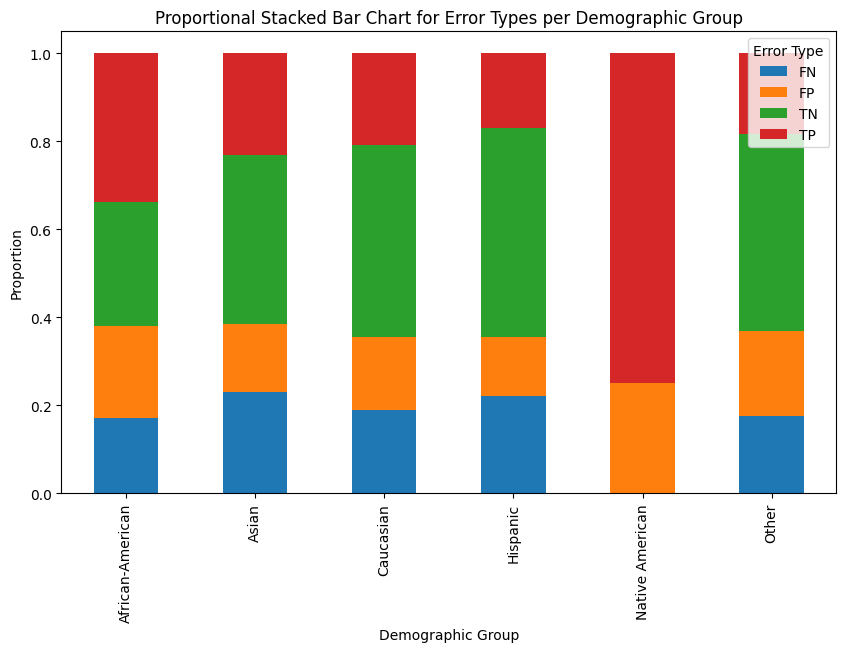

In [36]:
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = entire_dataset.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()



# Barchart error labels per gender

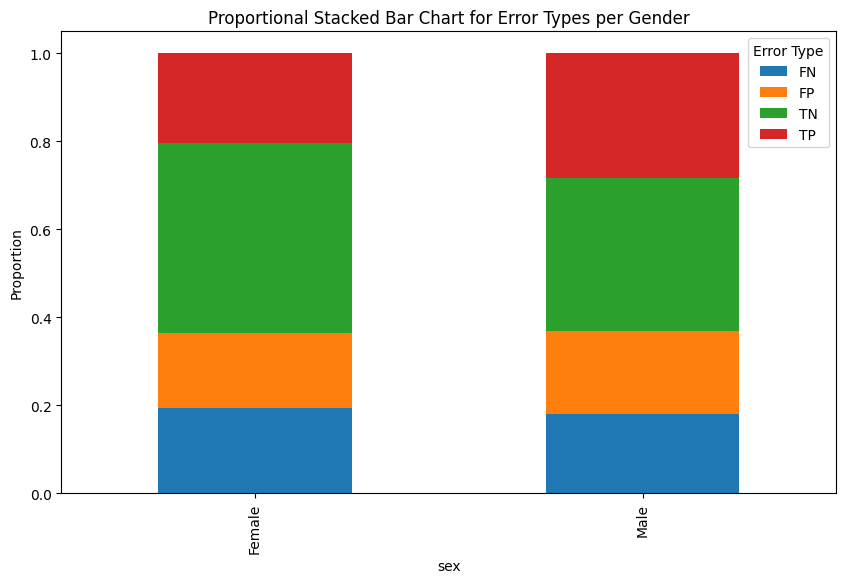

In [37]:
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = entire_dataset.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Bar Chart Error labels per Age

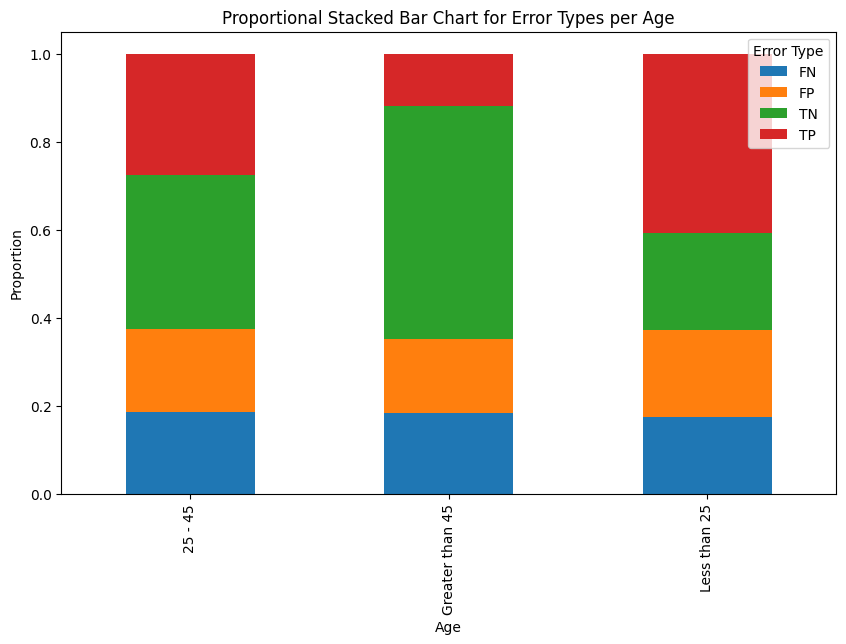

In [38]:
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = entire_dataset.groupby(['age_cat', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()


# Boxplot error label per age with jitter

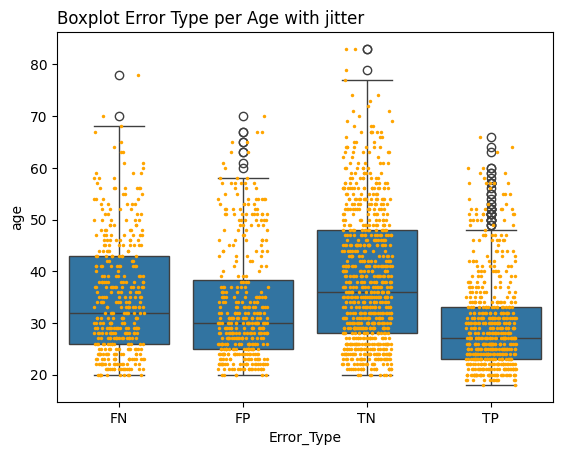

In [39]:
# boxplot
ax = sns.boxplot(x='Error_Type', y='age', data=entire_dataset)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=entire_dataset, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()

# Violinplot

In [40]:
#entire_dataset.info()
entire_dataset.head()

,age,decile_score,priors_count,v_decile_score,priors_count.1,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,...,true_class,errors,TP,TN,FN,FP,Error_Type,sex,age_cat,race
4372,24,4,1,4,1,1,0,0,0,1,...,0,0,0,1,0,0,TN,Female,Less than 25,African-American
6608,37,2,2,2,2,0,1,1,0,0,...,0,0,0,1,0,0,TN,Male,25 - 45,African-American
1313,45,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,TN,Male,Greater than 45,Other
3915,47,2,3,1,3,0,1,0,1,0,...,0,0,0,1,0,0,TN,Male,Greater than 45,Caucasian
1084,25,8,2,4,2,0,1,1,0,0,...,0,1,0,0,0,1,FP,Male,25 - 45,Caucasian


Violin plot as combination of boxplot and kernel density plot.

The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.


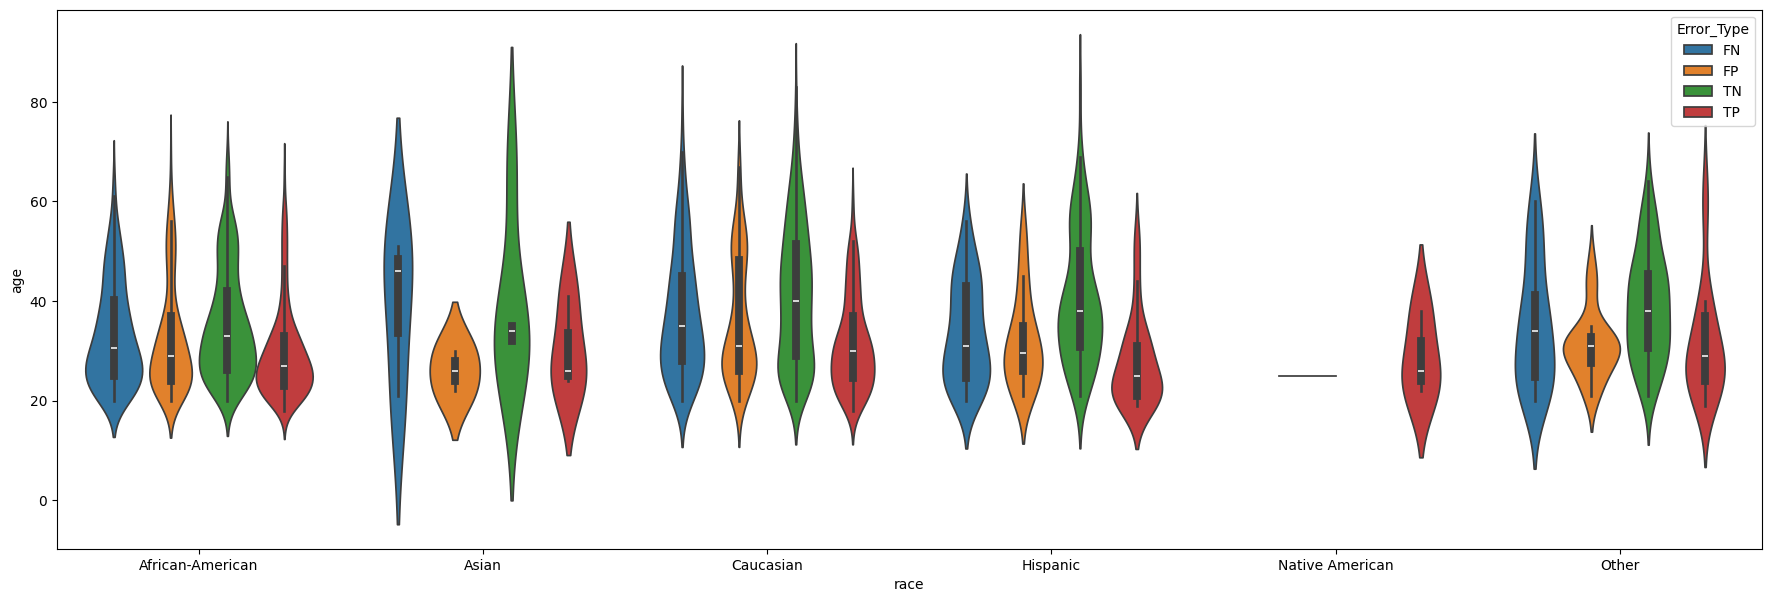

In [41]:
#sns.violinplot(x="Error_Type", y="age", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="age_cat", data=entire_dataset)
#plt.show()

#plt.figure(figsize=(3, 15))

#sns.violinplot(x="age", y="race", hue = "Error_Type", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="sex", data=entire_dataset)
#plt.show()

plt.figure(figsize=(22, 7))

sns.violinplot(x="race", y="age", hue = "Error_Type", data=entire_dataset)
plt.show()


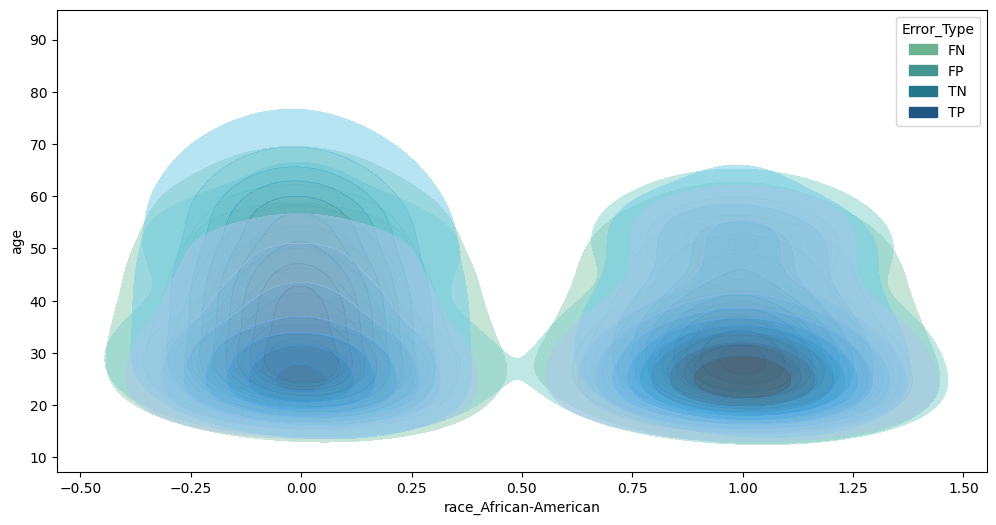

In [42]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data=entire_dataset, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)

plt.show()


In [43]:
entire_dataset.info()
entire_dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 4372 to 5966
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      2165 non-null   int64   
 1   decile_score             2165 non-null   int64   
 2   priors_count             2165 non-null   int64   
 3   v_decile_score           2165 non-null   int64   
 4   priors_count.1           2165 non-null   int64   
 5   sex_Female               2165 non-null   int64   
 6   sex_Male                 2165 non-null   int64   
 7   age_cat_25 - 45          2165 non-null   int64   
 8   age_cat_Greater than 45  2165 non-null   int64   
 9   age_cat_Less than 25     2165 non-null   int64   
 10  race_African-American    2165 non-null   int64   
 11  race_Asian               2165 non-null   int64   
 12  race_Caucasian           2165 non-null   int64   
 13  race_Hispanic            2165 non-null   int64   
 14  race_

,age,decile_score,priors_count,v_decile_score,priors_count.1,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,...,true_class,errors,TP,TN,FN,FP,Error_Type,sex,age_cat,race
4372,24,4,1,4,1,1,0,0,0,1,...,0,0,0,1,0,0,TN,Female,Less than 25,African-American
6608,37,2,2,2,2,0,1,1,0,0,...,0,0,0,1,0,0,TN,Male,25 - 45,African-American
1313,45,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,TN,Male,Greater than 45,Other
3915,47,2,3,1,3,0,1,0,1,0,...,0,0,0,1,0,0,TN,Male,Greater than 45,Caucasian
1084,25,8,2,4,2,0,1,1,0,0,...,0,1,0,0,0,1,FP,Male,25 - 45,Caucasian


# PCA

Each point represents an observation in entire_dataset. Points closer together have similar patterns across features. Culsters may indicate subgroups. Outliers deviate from the general pattern

Explained Variance Ratio: PC1 = 0.72, PC2 = 0.23


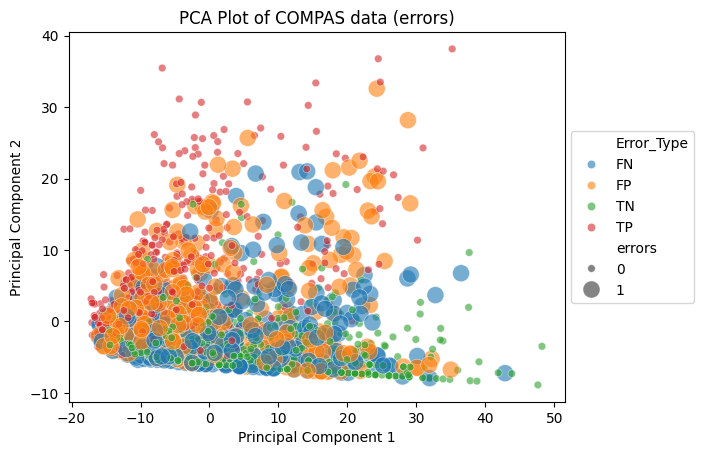

In [47]:
def pca_plot(data, title, alpha):
  #extracts the features for PCA, excluding columns that are not part of the features used for PCA. Other_features are used later for additional information in the plot
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age_cat', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'age_cat', 'race']]
    df = pd.DataFrame(pca_features)

    #applies PCA with 2 components to the features and creates a DataFrame with the resulting principal components
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index = df.index)
    temp_dataset = pca.join(other_features, how = 'left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(df).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

pca_plot(entire_dataset, 'PCA Plot of COMPAS data (errors)', 0.6)



# SHAP

In [45]:
!pip install shap
import shap

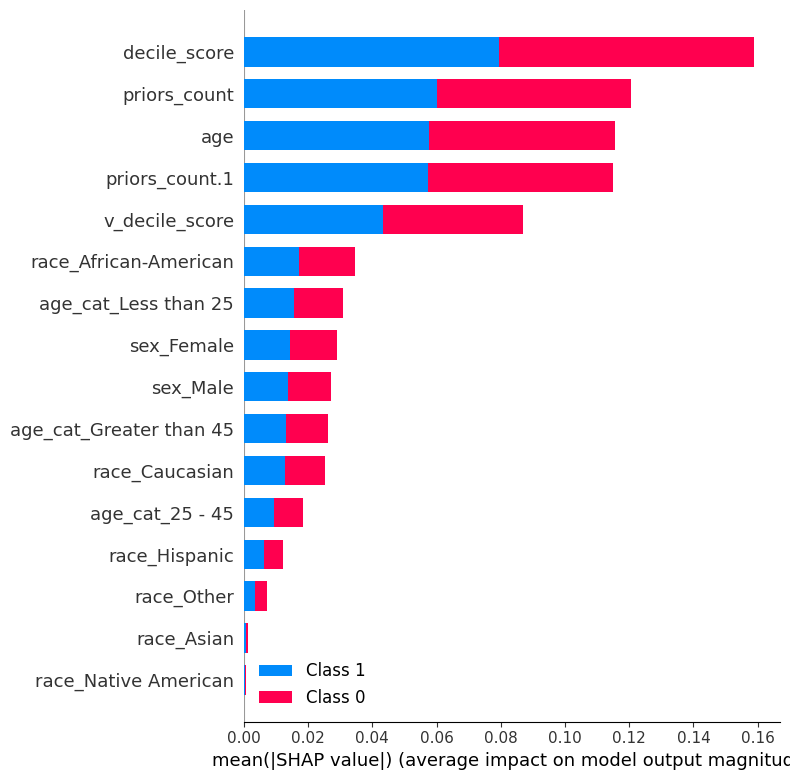

In [46]:
explainer = shap.TreeExplainer(model, approximate=True)
shap_values = explainer.shap_values(X1)
shap.summary_plot(shap_values, X1)
